In [5]:
import numpy as np
import random 
import matplotlib.pyplot as plt

In [172]:
class Network :
    def __init__(self,layers,activator,derivative,learningRate,epoch,loss,l2alpha =0):
        self.nLayers = len(layers)
        self.loss = loss
        self.weights = [np.random.randn(y, x) * np.sqrt(2. / (x + y)) for x, y in zip(layers, layers[1:])]
        self.bias = [np.random.randn(x,1) for x in layers[1:]]
        self.activator = activator
        self.derivative = derivative
        self.da = {}
        self.a = {}
        self.err = {}
        self.errB = {}
        self.learningRate = learningRate
        self.epoch = epoch
        self.avgGraW = [np.zeros_like(weight) for weight in self.weights]
        self.avgGraB = [np.zeros_like(bias) for bias in self.bias]
        self.l2Alpha = l2alpha
        self.n = 0
        self.m_w= [ np.zeros_like(w) for  w in self.weights]  
        self.v_w = [ np.zeros_like(w) for  w in self.weights]
        self.m_b= [ np.zeros_like(b) for  b in self.bias]  
        self.v_b = [np.zeros_like(b) for  b in self.bias]

    def innerTrain(self,x,y):
        self.inp = x
        out = x
        self.y = y
        self.n = x.shape[1]
        i =0
        for weight,bias in zip(self.weights,self.bias):
            z = np.matmul(weight,out) + bias
            out = self.activator[i](z)
            self.a[i] = out
            self.da[i] = self.derivative[i](z)
            i+=1
        if self.loss == 'mse':
            self.mse(out)
        if self.loss == 'crossEntropy':
            self.crossEntropy(out)
        self.backTracking(x,out)

    def mse(self,y_pred):
        error = self.y - y_pred
        error = np.square(error)
        self.error = error
        print("error : ",np.sum(error)/error.size)

    def crossEntropy(self,y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        err = self.y * np.log(y_pred)
        err=  np.sum(err)/err.size
        self.error = err
        print('Error : ',err)
    
    def backTracking(self,inp,y_pred):
       
        self.a[-1] = inp
        ws = [x for x in range(self.nLayers-1)][1:][::-1]
        a_s= [x for x in range(-1,self.nLayers-1)][:-1][::-1]
        da_s = [x for x in range(self.nLayers-1)][::-1]
        n = self.nLayers - 2 
        ws.insert(0,0)

        if(self.loss == 'mse'): 
            err = 2*(self.y - y_pred)
            d_mse = (-2/self.n)*(self.y - y_pred)
        elif self.loss == 'crossEntropy':
            y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
            d_mse = self.y - y_pred
       
        for w,a,da in zip(ws,a_s,da_s):
            if(w == 0):
                
                err = d_mse * self.da[da]
                
                p_err = err
                
                err = np.matmul(p_err,self.a[a].T)
                
            else:
                
                err = np.matmul(self.weights[w].T,p_err)
                
                p_err = err * self.da[da]
                
                err = np.matmul(p_err,self.a[a].T)
                
            self.err[n] = err
            self.errB[n] = np.average(p_err,axis=1,keepdims=True)

            n-=1
        self.Adam()

    
    def rmsProp(self, beta=0.5, epsilon=1e-6):
        for x in self.err.keys():
          
            self.avgGraW[x] = beta * self.avgGraW[x] + (1 - beta) * (self.err[x] ** 2)
            self.avgGraB[x] = beta * self.avgGraB[x] + (1 - beta) * (self.errB[x] ** 2)
            
            if(self.l2Alpha != 0):
                self.weights[x] = self.weights[x] -(self.learningRate/(np.sqrt(self.avgGraW[x] + epsilon)) *(self.err[x] + (2/self.n)*self.l2Alpha*self.weights[x]))
                self.bias[x] = self.bias[x] - self.learningRate*self.errB[x] / np.sqrt(self.avgGraB[x] + epsilon)
            else:
                self.weights[x] =self.weights[x] + self.learningRate * self.err[x] / (np.sqrt(self.avgGraW[x]) + epsilon)
                self.bias[x] = self.bias[x] + self.learningRate * self.errB[x] / (np.sqrt(self.avgGraB[x]) + epsilon)


    def Adam(self,beta1=0.8,beta2 = 0.9,epsion = 1e-7):

        for x in self.err.keys():
            
            self.m_w[x] = beta1 * self.m_w[x]  + (1 - beta1)*self.err[x]
            self.v_w[x]= beta2 * self.v_w[x] + (1-beta2)*np.square(self.err[x])

            m_t = self.m_w[x]/ (1 -beta1)
            v_t = self.v_w[x] / (1 -beta2)
            lern = self.learningRate * (m_t/np.sqrt(v_t + epsion))

            self.weights[x] = self.weights[x] - lern


        for x in self.err.keys():
            self.m_b[x] = beta1 * self.m_b[x] + (1 - beta1) * self.errB[x]
            self.v_b[x] = beta2 * self.v_b[x] + (1 - beta2) * np.square(self.errB[x])

            m_b_t = self.m_b[x] / (1 - beta1)
            v_b_t = self.v_b[x] / (1 - beta2)
            lern = self.learningRate * (m_b_t/np.sqrt(v_b_t + epsion))


            self.bias[x] = self.bias[x] - lern

    def update(self):
        for x in self.err.keys():
            self.weights[x] = self.weights[x] + self.learningRate*self.err[x]
            self.bias[x] = self.bias[x] + self.learningRate * self.errB[x]
    

    def predict(self,x):
        z = x
        i = 0
        for weight,bias in zip(self.weights,self.bias):
            z = np.matmul(weight,z)
            z = z + bias
            z = self.activator[i](z)
            i+=1

        return z
    
    
    def train(self,x,y):
        errors = []
        self.innerTrain(x,y)
        e = np.sum(self.error)/self.error.size
        errors.append(e)
        count = 0
        while(count <self.epoch):
            self.innerTrain(x, y)
            e = np.sum(self.error) / self.error.size
            errors.append(e)
            count += 1
        errors.append(0)
        plt.plot(range(len(errors)), errors, label="Training Error")
        plt.xlabel("Epochs")
        plt.ylabel("Error")
        plt.title("Error Reduction Over Time")
        plt.legend()
        plt.show()


In [7]:
def sigmoid(z):
    return 1/(1+np.exp(-1*z))

In [8]:
def dfSigmoid(z):
    num1 = sigmoid(z)
    num2 = 1 - num1

    return num1*num2

In [9]:
def Relu(z):
    return np.maximum(0,z)

In [10]:
def dfRelu(x):
    return np.where(x > 0, 1, 0)

In [11]:
def linear(x):
    return x

In [12]:
def dfLinear(x):
    return 1

In [13]:
def tanh(z):
    z = np.tanh(z)

    return z

In [14]:
def dfTanh(z):

    z = tanh(z)

    return 1 - (z**2)

error :  0.16773235431300243
error :  0.1590634358397595
error :  0.14818323196865324
error :  0.1364551314565862
error :  0.12460900171533164
error :  0.11308586158343652
error :  0.10216078550742948
error :  0.09200310139077164
error :  0.08271080770870957
error :  0.07433199062943503
error :  0.0668787990307434
error :  0.06033679258165999
error :  0.054671260759967755
error :  0.04983151733167632
error :  0.045753881609559455
error :  0.04236393333260051
error :  0.039578604887497544
error :  0.037308684713969226
error :  0.035462226144675923
error :  0.03394899739301707
error :  0.03268540443076118
error :  0.03159869207453883
error :  0.030629357723695013
error :  0.02973154117959464
error :  0.028871907364472805
error :  0.028027770219048023
error :  0.0271850453475851
error :  0.02633634390564741
error :  0.025479304992605374
error :  0.024615155933286323
error :  0.023747464147202035
error :  0.022881058308161527
error :  0.022021118691282492
error :  0.021172451518871392
erro

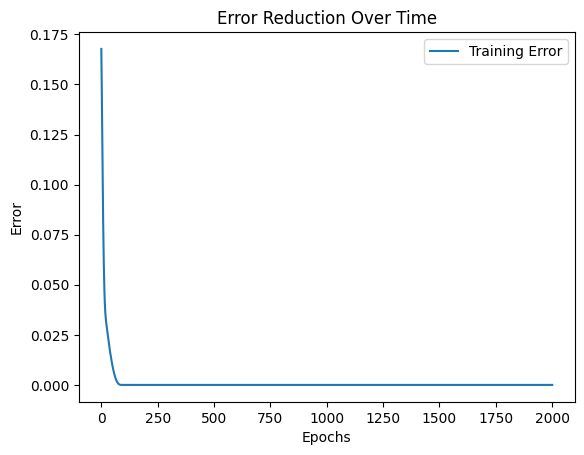

In [266]:
# Generate synthetic data
x1 = np.array([random.randint(1, x) for x in range(1,100)])
x2 = np.array([random.randint(1, x) for x in range(1,100)])
y1 = x1 + x2**3

x1_mean, x1_std = np.mean(x1), np.std(x1)
x2_mean, x2_std = np.mean(x2**3), np.std(x2**3)
y_mean, y_std = np.mean(y1), np.std(y1)

x11 = x1[50:]
x21 = x2[50:]

x1_1 = x1[:50]
x2_1 = x2[:50]

y = y1[:50]


x1_1 = (x1_1 - x1_mean) / x1_std
x2_1 = ((x2_1**3) - x2_mean) / x2_std
x = np.array([x1_1, x2_1])


y = (y - y_mean) / y_std
ty = y
n = Network(
    [2, 8, 1],  
    [linear,linear,linear],
    [dfLinear, dfLinear,dfLinear],
    learningRate=0.001,  
    epoch=2000,
    loss='mse',
    l2alpha=0.03
)
n.train(x, y)


In [267]:



y = y1[50:]



x11 =  (x11 - x1_mean) / x1_std
x21 = ((x21**3) - x2_mean) / x2_std
x = np.array([x11, x21])

tolerance =50

y_pred_norm = n.predict(x)

y_pred = y_pred_norm * y_std + y_mean

errors = np.abs(y - y_pred)
correct_predictions = np.sum(errors < tolerance)

accuracy = correct_predictions / len(y)

print("Accuracy:", accuracy)

Accuracy: 1.0


In [272]:
x111 = np.array([32])
x211 = np.array([40])

x11 = (x111 - x1_mean) / x1_std
x21 = ((x211**3) - x2_mean) / x2_std
x = np.array([x11, x21])


y_pred_norm = n.predict(x)
y_pred = y_pred_norm * y_std + y_mean
y_pred +37

array([[64047.6930931]])